# IV analyse of juxtacellular data
Data provided by Daniel English and Sam McKenzie

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
import quantities as pq
import seaborn as sns
import sys
from exana.stimulus import plot_psth
import scipy
import neo

### Load files and convert to neo

In [3]:
ses = scipy.io.loadmat('../data/JuxtaGroundTruth.mat')

blks = []

for ses_i in ses['ses'][0]:
    sesi_dict = {'stimTimes': ses_i[0],
                 'name': ses_i[1],
                 'ID': ses_i[2],
                 'juxta_ID': ses_i[3],
                 'times': ses_i[4],
                 'rippleTimes': ses_i[5],}
    blk = neo.Block(name=sesi_dict['name'])
    
    seg = neo.Segment()
    chx_units = neo.ChannelIndex(index=0,
                                 name='units')
    blk.channel_indexes.append(chx_units)
    
    # load spike times
    
    unique_neuron_ids = np.unique(sesi_dict['ID'], axis=0)
    for neuron_id_i in unique_neuron_ids:
        unit_i = neo.Unit(name=str(neuron_id_i),
                          electrode=neuron_id_i[0],
                          cluster=neuron_id_i[1])
        
        spkts_idcs = np.where((sesi_dict['ID']==neuron_id_i).all(axis=1))
        spkts = sesi_dict['times'][spkts_idcs]
        spk_train = neo.SpikeTrain(times=spkts*pq.s,
                                   t_start=np.min(spkts)*pq.s,
                                   t_stop=np.max(spkts)*pq.s)
        spk_train.unit = unit_i
        seg.spiketrains.append(spk_train)
        unit_i.spiketrains.append(spk_train)
        chx_units.units.append(unit_i)
        
    # load stimulation epochs
    stim_start = sesi_dict['stimTimes'][:, 0]
    stim_dur = sesi_dict['stimTimes'][:, 1] - sesi_dict['stimTimes'][:, 0]
    
    epc = neo.Epoch(times=stim_start*pq.s,
                    durations=stim_dur*pq.s,
                    name='Stim', descriptions=str(sesi_dict['juxta_ID']))
    seg.epochs.append(epc)
    blk.segments.append(seg)
    blks.append(blk)

## 1) PSTH
### Aim
Determine reasonable latencies for IV analyses.

### 1a) We start by looking at PSTHs of the first session


/opt/conda/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


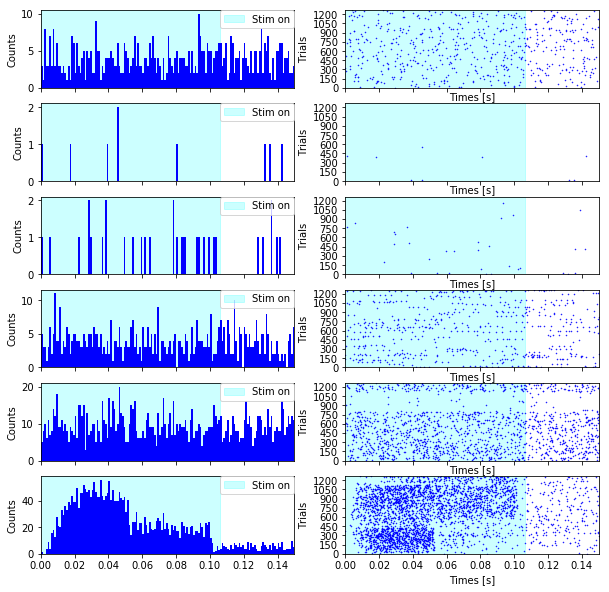

In [4]:
# start with a single example

blk = blks[0]
seg=blk.segments[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]
xlim = [0, 150] * pq.ms


fig, axs = plt.subplots(len(spktrns),2,
                        sharex=True,
                        figsize=(10,10))
for i, spktrn_i in enumerate(spktrns):
    plot_psth(spike_train=spktrn_i,
              epoch=epc,
              xlim=xlim,
              axs=[axs[i, 0], axs[i, 1]],
              hist_binsize=1*pq.ms,
              stim_color='cyan',
              hist_alpha=1.,
              hist_edgecolor=None, 
              hist_ylabel='Counts',
              rast_size=1);

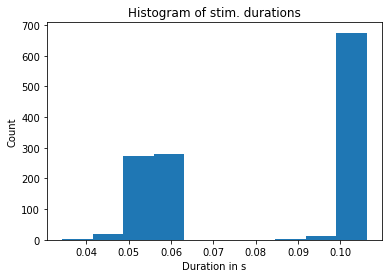

In [5]:
fig, ax = plt.subplots(1)
ax.hist(epc.durations.magnitude)
ax.set_title('Histogram of stim. durations')
ax.set_xlabel('Duration in ' + str(epc.durations.dimensionality))
ax.set_ylabel('Count')
plt.show()

### Observation
* Only few cells per session.
* Some with very low firing rate
* Some with relative high rate (maybe interneurons?)
* Stimulated cell (last row) has a relative slow onset, reaching peak firing rate after 20 ms.
* Stimulated cell seems to cease firing directly after stimulation onset

### Questions:
How to 
